In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import scipy.stats as stats
import netgraph

import seaborn as sns
import json
import openai
import random
import os
import collections
import copy


MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']

def summarize_reasons(filename, n_samples=20, n_categories=4, n_resamples=5, categories=None):
    random.seed(1)
    np.random.seed(1)

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    all_reasons = []

    for d in data:        
        for results in d["reasons"]:
            for result in results:
                if result and 'reason' in result.keys():
                    reason_list[d['temperature']].append(result['reason'])
                    all_reasons.append(result['reason'])

    if categories is None:
        categorization_prompt = f"""
        # Task

        You are given a list of reasons and your task to find {n_categories} categories that best describe the reasons.

        # Input

        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(random.sample(all_reasons, len(reason_list) * n_samples))}
        </REASONS>

        # Output

        The output should be given in JSON format with the following structure:

        [
            {{
                "category" : category,
                "description" : short description of the category
            }}, ...
        ]

        # Notes
        * The names of the categories must be descriptive and mutually exclusive.

        ```json
        """

        for _ in range(10):
            try:
                ans = get_response(categorization_prompt, temperature=0, system_prompt="You are a helpful assistant")
                categories = json.loads(ans.split('```')[0])
                print(categories)
                break

            except Exception as e:
                print(e)
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    category_list = [c['category'] for c in categories]

    records = []

    for i, (k, v) in enumerate(reason_list.items()):
        print('Temperature', k)
        if len(v) <= n_samples:
            n_resamples = 1

        for r in range(n_resamples):
            prompt = f"""
            # Task
            You are given a list of reasons and your task is to classify them into categories.

            # Input
            The input is a list of reasons. The list is given below after chevrons:
            <REASONS>
            {json.dumps(random.sample(v, n_samples), indent=4)}
            </REASONS>

            ## Categories
            The names of the categories are given below after chevrons:
            <CATEGORIES>
            {json.dumps(categories, indent=4)}
            </CATEGORIES>

            Each reason must be assigned to exactly one of the categories.
            
            # Output
            The output should be given as a list of JSON objects with the following structure:

            [
                {{
                        "reason" : reason,
                        "category" : category name
                }}, ...
            ]

            ```json
            """

            for _ in range(10):
                try:
                    ans = get_response(prompt, temperature=0, system_prompt="You are a helpful assistant")

                    result = json.loads(ans.split('```')[0])

                    assert(isinstance(result, list))

                    reason_types = collections.defaultdict(float)

                    total = 0

                    for reason in result:
                        if reason['category'] in category_list:
                            reason_types[reason['category']] += 1
                            total += 1

                    for key, val in reason_types.items():
                        reason_types[key] = val / total * 100

                   
                    break
                except Exception as e:
                    print(e)

            for key, val in reason_types.items():
                records.append({
                    'Temperature' : k,
                    'Category' : key,
                    'Frequency' : val,
                    'Resample' : r
                })


    df = pd.DataFrame.from_records(records)

    fig.suptitle('Reasoning for Principle 3', fontsize=MEDIUM_SIZE)

    sns.barplot(data=df, x='Category', y='Frequency', hue='Temperature', ax=ax, palette='Set2')

    plt.legend(fontsize=0.75*SMALL_SIZE, title='Temperature')

    plt.xticks(rotation=0, fontsize=SMALL_SIZE)

    fig.tight_layout()

    fig.savefig(f'figures/principle_3/principle_3_reasons.png', dpi=300, bbox_inches='tight')

def print_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    for d in data:
        if d["n"] == 50 and d["simulation"] == 0:
            print(f'n = {d["n"]}, simulation = {d["simulation"]}, temperature = {d["temperature"]}')
            
            for result in d["reasons"]:
                
                    try:
                        print('\t' + result['reason'])
                    except:
                        pass

def generate_individuals(n):
    profiles = []

    hobbies = ['reading', 'writing', 'cooking']
    colors = ['red', 'orange', 'yellow', 'green']
    
    # Locations in the US
    locations = ['New York City', 'Boston', 'Washington DC']

    # hobbies = ['reading', 'writing', 'cooking', 'baking', 'running', 'swimming', 'hiking', 'camping', 'fishing', 'hunting']
    # colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'black', 'white']
    
    # # Locations in the US
    # locations = ['New York City', 'Boston', 'Washington DC', 'Philadelphia', 'Pittsburgh', 'Chicago', 'Detroit', 'Atlanta', 'Miami', 'Dallas']

    for i in range(n):
        profile = {
            'name' : i,
            'hobby' : random.choice(hobbies),
            'favorite color' : random.choice(colors),
            'location' : random.choice(locations)
        }

        profiles.append(profile)

    with open('outputs/profiles.jsonl', 'w+') as f:
        [f.write(json.dumps(profile) + '\n') for profile in profiles]


def network_growth(n0, temperature, method='llm'):
    with open('profiles.jsonl') as f:
        profiles = f.read().splitlines()
        profiles = [json.loads(profile) for profile in profiles]

    profiles = profiles[:n0]

    G = nx.Graph()
    G.add_nodes_from(range(n0))

    Gs = []
    results = []

    for t in range(n0):

        if method == 'llm':
            result = select_neighbor(G, t, profiles, temperature)

            if result:
                for r in result:
                    v = r['name']
                    G.add_edge(t, v, similarity=r['similarity'])
                results.append(result)
        elif method in ['random', 'homophilous', 'heterophilous']:
            if method == 'random':
                new_nodes = random.sample(list(set(G.nodes()) - set([t])), 4)
            elif method == 'homophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v])), reverse=True))[:4]
            elif method == 'heterophilous':
                new_nodes = list(sorted([v for v in G.nodes() if v != t], key=lambda v: len(set(profile_set(profiles[t])) & profile_set(profiles[v]))))[:4]
            
            for v in new_nodes:
                intersection = list(set(profile_set(profiles[t])) & profile_set(profiles[v]))
                union = list(set(profile_set(profiles[t])) | profile_set(profiles[v]))
                similarity = len(intersection)
                G.add_edge(t, v, intersection=intersection, union=union, similarity=similarity)
            
            results.append([{'name' : v, 'intersection' : intersection, 'union' : union, 'similarity' : similarity} for v in new_nodes])
       
        Gs.append(G.copy())

    return Gs, results

def profile_set(p):
    return set([p['hobby']] + [p['favorite color']] + [p['location']])

def select_neighbor(G, t, profiles, temperature):
    candidate_profiles = []
    for v in G.nodes():
        if v != t:          
            candidate_profiles.append(profiles[v])
    

    prompt = f"""
    # Task
    Your task is to select a set of people to be friends with.

    # Profile
    Your profile is given below after chevrons:
    <PROFILE>
    {json.dumps(profiles[t])}
    </PROFILE>

    # Candidate Profiles
    The cadidate profiles to be friends with are given below after chevrons:

    <PROFILES>
    {json.dumps(candidate_profiles)}
    </PROFILES>

    # Output
    The output should be given a list of JSON objects with the following structure

    [
        {{
            "name" : name of the person you selected,
            "reason" : reason for selecting the person
        }}, ...
    ]

    # Notes
    - The output must be a list of JSON objects ranked in the order of preference.
    - You can make at most 4 selections.
    
    ```json
    """   

    for i in range(10):
        try:
            results = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            filtered_results = []
            for result in results:
                if result['name'] in G.nodes():
                    v = result['name']
                    result['intersection'] = list(profile_set(profiles[t]) & profile_set(profiles[v]))
                    result['union'] = list(profile_set(profiles[t]) | profile_set(profiles[v]))
                    result['similarity'] = len(result['intersection'])
                    filtered_results.append(result)

            print(f'Node: {t}, Results: {filtered_results}')

            return filtered_results

        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')

                    Gs, reasons = network_growth(n, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_dicts(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, communities=None, palette=None, use_netgraph=True, ego_network=False):

    if not use_netgraph:
        pos = nx.spring_layout(G, weight='similarity')
    
        if communities:
            for i, community in enumerate(communities):
                nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_size=20, node_color=palette[i], ax=ax)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=20, node_color='#d35400', ax=ax)

        edge_widths = [1 + G.edges[u, v]['similarity'] for (u, v) in G.edges()]

        nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), width=edge_widths, edge_color='#34495e', alpha=0.5, ax=ax)
    elif use_netgraph and not ego_network:
        node2community = {node: i for i, community in enumerate(communities) for node in community}
        node_color = {node : palette[node2community[node]] for node in G.nodes()}
        edge_widths = {(u, v) : (1 + G.edges[u, v]['similarity']) * 0.5 for (u, v) in G.edges()}

        # netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_width=edge_widths, edge_color='#34495e', edge_layout='bundled', edge_layout_kwargs=dict(k=2000), ax=ax)
        netgraph.Graph(G, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=2.5, edge_width=edge_widths, edge_color='#34495e', ax=ax)

    elif use_netgraph and ego_network:
        ego_net = nx.ego_graph(G, list(G.nodes())[0], radius=1)

        node2community = {node: i for i, community in enumerate(communities) for node in community}

        node_color = {node : palette[node2community[node]] for node in ego_net.nodes()}
        node_size = {}

        for node in ego_net.nodes():
            if node == list(G.nodes())[0]:
                node_size[node] = 5
            else:
                node_size[node] = 2.5

        edge_widths = {(u, v) : (1 + ego_net.edges[u, v]['similarity']) * 0.5 for (u, v) in ego_net.edges()}
        netgraph.Graph(ego_net, node_layout='community', node_color=node_color, node_layout_kwargs=dict(node_to_community=node2community), node_size=node_size, edge_width=edge_widths, edge_color='#34495e', ax=ax)

    ax.set_axis_off()


def analyze_experiments(filename):

    palette = ['#d35400', '#34495e', '#2980b9', '#e67e22', '#f1c40f', '#7f8c8d', '#27ae60', '#16a085', '#bdc3c7', '#1abc9c', '#2ecc71', '#3498db', '#9b59b6', '#8e44ad', '#ecf0f1']

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []


    for line in lines:
        data.append(json.loads(line))

    edge_similarity_distributions = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    wasserstein_distance = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list) }
    louvain_communities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    louvain_modularity = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list) }
    location_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}
    favorite_color_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}
    hobby_assortativities = { 'homophilous' : collections.defaultdict(list), 'random' : collections.defaultdict(list), 'heterophilous' : collections.defaultdict(list), 'llm' : collections.defaultdict(list)}

    final_graphs = collections.defaultdict(list)

    with open('outputs/profiles.jsonl') as f:
        profiles = f.read().splitlines()
        profiles = [json.loads(profile) for profile in profiles]

    profiles_dict = {str(profile['name']) : profile for profile in profiles}

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.from_dict_of_dicts(graph)
            
            nx.set_node_attributes(G, profiles_dict)

            G.remove_edges_from(nx.selfloop_edges(G))
            # G.remove_nodes_from(list(nx.isolates(G)))

            Gs.append(G)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        louvain_communities['llm'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(Gs[-1], weight='similarity'))
        louvain_modularity['llm'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(Gs[-1], louvain_communities['llm'][d['n'], d['temperature']][-1], weight='similarity'))


        final_graphs[d['n'], d['temperature']].append((Gs[-1], louvain_communities['llm'][d['n'], d['temperature']][-1]))


        G_homophilous = network_growth(d['n'], d['temperature'], method='homophilous')[0][-1]
        G_heterophilous = network_growth(d['n'], d['temperature'], method='heterophilous')[0][-1]
        G_random = network_growth(d['n'], d['temperature'], method='random')[0][-1]

        nx.set_node_attributes(G_homophilous, {int(profile['name']) : profile for profile in profiles})
        nx.set_node_attributes(G_heterophilous, {int(profile['name']) : profile for profile in profiles})
        nx.set_node_attributes(G_random, {int(profile['name']) : profile for profile in profiles})

        ax[0].set_title(f'Temperature = {d["temperature"]}')
        
        draw_graph(Gs[-1], ax=ax[0], communities=louvain_communities['llm'][d['n'], d['temperature']][-1], palette=palette)

        edge_similarity_distribution = [G.edges[u, v]['similarity'] for (u, v) in Gs[-1].edges()]
        edge_similarity_distribution_homophilous = [G_homophilous.edges[u, v]['similarity'] for (u, v) in G_homophilous.edges()]
        edge_similarity_distribution_heterophilous = [G_heterophilous.edges[u, v]['similarity'] for (u, v) in G_heterophilous.edges()]
        edge_similarity_distribution_random = [G_random.edges[u, v]['similarity'] for (u, v) in G_random.edges()]

        wasserstein_distance['homophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_homophilous))
        wasserstein_distance['heterophilous'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_heterophilous))
        wasserstein_distance['random'][d['n'], d['temperature']].append(stats.wasserstein_distance(edge_similarity_distribution, edge_similarity_distribution_random))

        print(f'Temperature: {d["temperature"]} T-test Test Homophilous: {stats.ttest_ind(edge_similarity_distribution, edge_similarity_distribution_homophilous, equal_var=False, alternative="less")}')
        print(f'Temperature: {d["temperature"]} T-test Test Random: {stats.ttest_ind(edge_similarity_distribution, edge_similarity_distribution_random, equal_var=False, alternative="two-sided")}')
    

        edge_similarity_distributions['homophilous'][d['n'], d['temperature']].extend(edge_similarity_distribution_homophilous)
        edge_similarity_distributions['heterophilous'][d['n'], d['temperature']].extend(edge_similarity_distribution_heterophilous)
        edge_similarity_distributions['random'][d['n'], d['temperature']].extend(edge_similarity_distribution_random)
        edge_similarity_distributions['llm'][d['n'], d['temperature']].extend(edge_similarity_distribution)

        louvain_communities['homophilous'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(G_homophilous, weight='similarity'))
        louvain_communities['random'][d['n'], d['temperature']].append(nx.algorithms.community.louvain_communities(G_random, weight='similarity'))

        louvain_modularity['homophilous'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(G_homophilous, louvain_communities['homophilous'][d['n'], d['temperature']][-1], weight='similarity'))
        louvain_modularity['random'][d['n'], d['temperature']].append(nx.algorithms.community.modularity(G_random, louvain_communities['random'][d['n'], d['temperature']][-1], weight='similarity'))

        location_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'location'))
        location_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'location'))
        location_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'location'))
        location_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'location'))

        favorite_color_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'favorite color'))
        favorite_color_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'favorite color'))
        favorite_color_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'favorite color'))
        favorite_color_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'favorite color'))

        hobby_assortativities['homophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_homophilous, 'hobby'))
        hobby_assortativities['heterophilous'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_heterophilous, 'hobby'))
        hobby_assortativities['random'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(G_random, 'hobby'))
        hobby_assortativities['llm'][d['n'], d['temperature']].append(nx.attribute_assortativity_coefficient(Gs[-1], 'hobby'))


        sns.histplot(edge_similarity_distribution, ax=ax[1], label='LLM', color='#d35400', binwidth=0.45, discrete=True, stat='density')
        ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1))
        
        ax[1].set_xlabel('Number of Common Attributes')
        ax[1].set_ylabel('Probability of Edge Creation')
        ax[1].set_ylim(0, 0.75)
        ax[1].legend()

        fig.tight_layout()
        fig.savefig(f'figures/principle_3/principle_3_profiles_{d["n"]}_{d["simulation"]}_{d["temperature"]}.png', dpi=300)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))


    ax[0].set_xlabel('Temperature')
    ax[0].set_ylabel('Wasserstein Distance')


    wasserstein_distance_means = { 'homophilous' : [], 'heterophilous' : [], 'random' : [] }
    wasserstein_distance_stds = { 'homophilous' : [],  'heterophilous' : [], 'random' : [] }

    for method, color in zip(['homophilous', 'heterophilous', 'random'], palette[:3]):
        for i, k in enumerate(sorted(wasserstein_distance[method].keys())):
            v = np.array(wasserstein_distance[method][k])
            mean = v.mean()
            std = v.std()

            wasserstein_distance_means[method].append(mean)
            wasserstein_distance_stds[method].append(std)

    for method, color in zip(['homophilous', 'random'], palette[:3]):
        
        ax[0].plot(np.arange(len(wasserstein_distance[method])), wasserstein_distance_means[method], label=method.capitalize(), marker='o', color=color)
        ax[0].fill_between(np.arange(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) - 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), np.array(wasserstein_distance_means[method]) + 1.96 * np.array(wasserstein_distance_stds[method]) / np.sqrt(len(wasserstein_distance[method])), alpha=0.2, color=color)

    ax[0].set_xticks(np.arange(len(wasserstein_distance['homophilous'])))
    ax[0].set_xticklabels([f'{k[1]}' for k in sorted(wasserstein_distance['homophilous'].keys())])
    ax[0].legend()
    ax[0].set_ylabel(f'Wasserstein Distance')


    objs = []

    for i, k in enumerate(sorted(edge_similarity_distributions['llm'].keys())):
        objs.append(pd.DataFrame.from_dict({'Number of Common Attributes' : edge_similarity_distributions['llm'][k], 'Method' : f'{k[1]}'}))

        if i == len(edge_similarity_distributions['llm'].keys()) - 1:
            for method in ['homophilous', 'random']:
                objs.append(pd.DataFrame.from_dict({'Number of Common Attributes' : edge_similarity_distributions[method][k], 'Method' : method.capitalize()}))


    df = pd.concat(axis=0, ignore_index=True, objs=objs)

    sns.histplot(
        data=df, x='Number of Common Attributes', hue='Method', multiple='dodge', palette=palette,
        bins=range(4), ax=ax[1], discrete=True, shrink=0.8, stat='probability', common_norm=False
    )

    sns.move_legend(ax[1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    ax[1].set_ylabel('Probability of Edge Creation')

    fig.tight_layout()
    
    fig.savefig('figures/principle_3/principle_3_profiles_overall.png', dpi=300)

    fig, ax = plt.subplots(1, len(final_graphs), figsize=(5 * (len(final_graphs)), 5))

    for i, (k, v) in enumerate(sorted(final_graphs.items())):
        G = v[0][0]
        communities = v[0][1]        
        ax[i].set_title(f"Temperature = {k[-1]}", fontsize=MEDIUM_SIZE)
        draw_graph(G, ax=ax[i], communities=communities, palette=palette)


    # sns.histplot(
    #     data=df, x='Number of Common Attributes', hue='Method', multiple='dodge',
    #     bins=range(4), ax=ax[-1], discrete=True, shrink=0.8, stat='probability', common_norm=False, palette=palette
    # )

    # sns.barplot(
    #     data=df, y='Number of Common Attributes', x='Method', ax=ax[-1], palette=palette
    # )

    # plt.xticks(fontsize=SMALL_SIZE, rotation=90)


    # sns.move_legend(ax[-1], bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

    # ax[-1].set_ylabel('# Common Attributes')

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_profiles_final_graphs.png', dpi=300, bbox_inches='tight')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].set_ylabel('Louvain Modularity')
    ax[1].set_ylabel('Number of Communities')
    ax[2].set_ylabel('Community Size')

    j = 0

    for method in ['llm']:
        for i, k in enumerate(sorted(louvain_modularity[method].keys())):
            if method != 'llm' and i != 0:
                continue

            modularities = np.array(louvain_modularity[method][k])
            number_of_communities = np.array([len(c) for c in louvain_communities[method][k]])
            community_sizes = np.array([len(v) for c in louvain_communities[method][k] for v in c])

            # mean = v.mean()
            # std = v.std()

            if method == 'llm':
                label = f'Temp = {k[-1]}'
            else:
                label = method.capitalize()


            sns.distplot(modularities, hist=False, ax=ax[0], label=label, color=palette[j])
            sns.distplot(number_of_communities, hist=False, ax=ax[1], label=label, color=palette[j])
            sns.distplot(community_sizes, hist=False, ax=ax[2], label=label, color=palette[j])

            j += 1

            for r, k_prime in enumerate(sorted(louvain_modularity[method].keys())):
                if k_prime[-1] < k[-1]:
                    
                    modularities_prime = np.array(louvain_modularity[method][k_prime])
                    number_of_communities_prime = np.array([len(c) for c in louvain_communities[method][k_prime]])
                    community_sizes_prime = np.array([len(v) for c in louvain_communities[method][k_prime] for v in c])

                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Modularity: {stats.ttest_ind(modularities, modularities_prime, equal_var=False, alternative="greater")}')
                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Number of Communities: {stats.ttest_ind(number_of_communities, number_of_communities_prime, equal_var=False, alternative="greater")}')
                    print(f'T-test Temperatures: {k[-1]}, {k_prime[-1]} Community Sizes: {stats.ttest_ind(community_sizes, community_sizes_prime, equal_var=False, alternative="less")}')
                    

    ax[0].legend(loc='upper left')
    ax[0].set_xlim(-0.5, 1)

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_profiles_louvain_modularity.png', dpi=300, bbox_inches='tight')

    assortativities_records = []

    for method in ['llm', 'random']:
        for i, k in enumerate(sorted(location_assortativities[method].keys())):
            if method == 'llm':
                label = f'{k[-1]}'
            else:
                label = method.capitalize()

            for v in location_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Location' : v,
                })

            for v in favorite_color_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Color' : v,
                })

            for v in hobby_assortativities[method][k]:
                assortativities_records.append({
                    'Method' : label,
                    'Hobby' : v,
                })


    df = pd.DataFrame.from_records(assortativities_records)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    fig.suptitle('Attribute Assortativities', fontsize=MEDIUM_SIZE)

    sns.barplot(data=df, x='Method', y='Location', ax=ax[0], palette=palette)
    sns.barplot(data=df, x='Method', y='Color', ax=ax[1], palette=palette)
    sns.barplot(data=df, x='Method', y='Hobby', ax=ax[2], palette=palette)
    
    for i in range(3):
        for tick in ax[i].get_xticklabels():
            tick.set_fontsize(SMALL_SIZE)

        ax[i].set_xlabel('')

    fig.tight_layout()

    fig.savefig('figures/principle_3/principle_3_assortativities.png', dpi=300, bbox_inches='tight')

   

In [2]:
if not os.path.exists('outputs/profiles.jsonl'):
    generate_individuals(50)

Skipping simulation for n=50, i=0, temperature=0.5
Skipping simulation for n=50, i=0, temperature=1.0
Skipping simulation for n=50, i=0, temperature=1.5
Skipping simulation for n=50, i=1, temperature=0.5
Skipping simulation for n=50, i=1, temperature=1.0
Skipping simulation for n=50, i=1, temperature=1.5
Skipping simulation for n=50, i=2, temperature=0.5
Skipping simulation for n=50, i=2, temperature=1.0
Skipping simulation for n=50, i=2, temperature=1.5
Skipping simulation for n=50, i=3, temperature=0.5
Skipping simulation for n=50, i=3, temperature=1.0
Skipping simulation for n=50, i=3, temperature=1.5
Skipping simulation for n=50, i=4, temperature=0.5
Skipping simulation for n=50, i=4, temperature=1.0
Skipping simulation for n=50, i=4, temperature=1.5
Skipping simulation for n=50, i=5, temperature=0.5
Skipping simulation for n=50, i=5, temperature=1.0
Skipping simulation for n=50, i=5, temperature=1.5
Skipping simulation for n=50, i=6, temperature=0.5
Skipping simulation for n=50, i

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-9.921465559643845, pvalue=1.6536861919868757e-20)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=8.224406235850553, pvalue=3.565830174001772e-15)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-13.677932871313857, pvalue=9.825726667008376e-34)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=3.1383574450388676, pvalue=0.0018356573976477963)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-11.706534427317468, pvalue=1.2777118136655948e-25)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=4.800848185637367, pvalue=2.458916754017052e-06)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.260981266229651, pvalue=1.4170945954170958e-21)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=6.37093158803053, pvalue=5.683743691982227e-10)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-10.053004009322041, pvalue=9.716720713539797e-21)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=6.237645980090799, pvalue=1.2883023478559933e-09)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-15.520214159913834, pvalue=3.7705541839852246e-39)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=2.295872798400821, pvalue=0.022309764579338996)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.426089334226898, pvalue=3.6477474350461404e-22)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=7.925779445621746, pvalue=3.063096662279826e-14)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-12.253300673686349, pvalue=2.8025827356890303e-28)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=4.315707365024458, pvalue=2.0580748421081243e-05)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-14.743144979828687, pvalue=1.4966824001231778e-36)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=3.3201441157844607, pvalue=0.0009978833850710063)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-9.625025006972837, pvalue=1.6623583022649143e-19)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=7.602959008010979, pvalue=2.5444937564472285e-13)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-12.310998148137537, pvalue=4.175551173072169e-28)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=4.307152526587062, pvalue=2.162508895715479e-05)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-14.082810544129954, pvalue=1.1349735258074957e-34)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=2.8390030867994906, pvalue=0.004785834701418845)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-9.888747968532014, pvalue=2.3351480818824614e-20)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=7.328661727191547, pvalue=1.5016830640652395e-12)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-12.436502695015863, pvalue=1.2870611798588196e-28)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=2.9974791298028123, pvalue=0.0029153777467515792)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-14.236006534485234, pvalue=6.83196981507554e-35)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=1.7860698185066755, pvalue=0.07497247558556444)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.2051215169042, pvalue=1.8622285916130545e-21)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=4.701430278207172, pvalue=3.6588611028098575e-06)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-11.923802308646895, pvalue=1.2131708308969327e-26)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=3.4812689531400003, pvalue=0.0005656305273116504)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-14.952606424795013, pvalue=3.531347942645267e-37)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=2.8040740900269427, pvalue=0.005340979001758063)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.319897059108223, pvalue=8.840300187725724e-22)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=7.400877962112716, pvalue=9.47358231016623e-13)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-13.42257770852014, pvalue=1.9775451230077013e-32)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=3.4583731742027, pvalue=0.0006079253639068139)


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_73799/126597590.py:485: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-12.910096129306641, pvalue=8.159571676585596e-30)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=4.305041930407582, pvalue=2.2313895308816164e-05)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.215156234709356, pvalue=1.6021178084935134e-21)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=7.331765829568289, pvalue=1.445219114631275e-12)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-12.301554682289925, pvalue=1.2932630223353012e-28)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=4.6433907591414645, pvalue=4.7728907753465785e-06)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-13.434681644127487, pvalue=2.175289619110071e-31)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=1.333850569736055, pvalue=0.18320433639624875)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-10.818584429985112, pvalue=2.471391867996323e-23)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=5.965982700005265, pvalue=5.950151517655461e-09)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-11.814052484977182, pvalue=5.5781917156496794e-27)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=4.416073417095826, pvalue=1.3211805687173691e-05)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-13.61490458303388, pvalue=4.0416581002298564e-32)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=2.8162584238368593, pvalue=0.0051800769366953815)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 0.5 T-test Test Homophilous: Ttest_indResult(statistic=-9.895308883141066, pvalue=2.4188844538168036e-20)
Temperature: 0.5 T-test Test Random: Ttest_indResult(statistic=6.818713281898285, pvalue=3.9746507183378644e-11)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.0 T-test Test Homophilous: Ttest_indResult(statistic=-13.511107481696426, pvalue=6.759992545338607e-33)
Temperature: 1.0 T-test Test Random: Ttest_indResult(statistic=3.48465197883646, pvalue=0.000554070644595012)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Temperature: 1.5 T-test Test Homophilous: Ttest_indResult(statistic=-11.44469443821557, pvalue=3.66981247442825e-24)
Temperature: 1.5 T-test Test Random: Ttest_indResult(statistic=3.9168829499748647, pvalue=0.00011291662600505918)


/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_73799/126597590.py:599: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  sns.histplot(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_73799/126597590.py:667: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(modularities, hist=False, ax=ax[0], label=label, color=palette[j])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_7

T-test Temperatures: 1.0, 0.5 Modularity: Ttest_indResult(statistic=1.376005056622953, pvalue=0.09334036135741386)
T-test Temperatures: 1.0, 0.5 Number of Communities: Ttest_indResult(statistic=1.7685190342396901, pvalue=0.05112222366655778)
T-test Temperatures: 1.0, 0.5 Community Sizes: Ttest_indResult(statistic=-1.5967240475117068, pvalue=0.05661482286336481)
T-test Temperatures: 1.5, 0.5 Modularity: Ttest_indResult(statistic=2.050346312903006, pvalue=0.028542704542522508)
T-test Temperatures: 1.5, 0.5 Number of Communities: Ttest_indResult(statistic=5.09133174976598, pvalue=0.00017908490898381702)
T-test Temperatures: 1.5, 0.5 Community Sizes: Ttest_indResult(statistic=-4.787338380326421, pvalue=2.3186986295238957e-06)
T-test Temperatures: 1.5, 1.0 Modularity: Ttest_indResult(statistic=0.7088549206866999, pvalue=0.24381312363595087)
T-test Temperatures: 1.5, 1.0 Number of Communities: Ttest_indResult(statistic=3.037737332500264, pvalue=0.003712744605870943)
T-test Temperatures: 1.5,

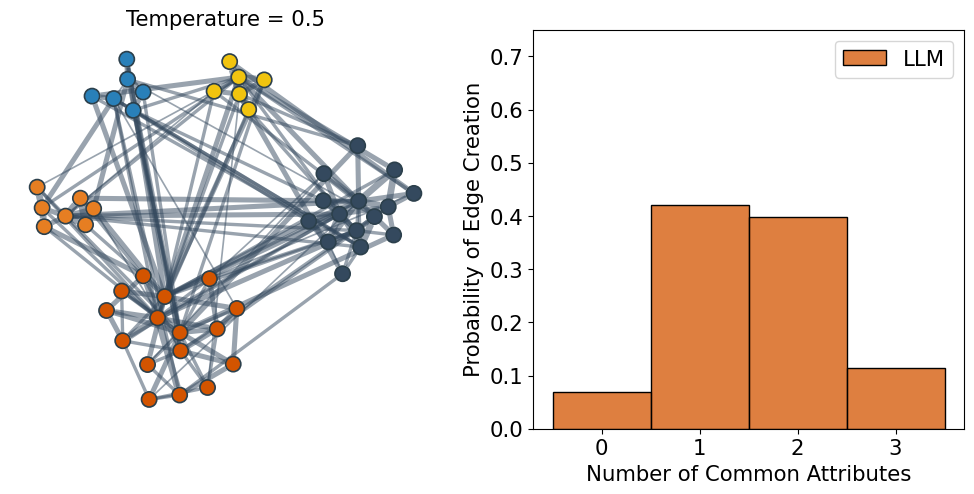

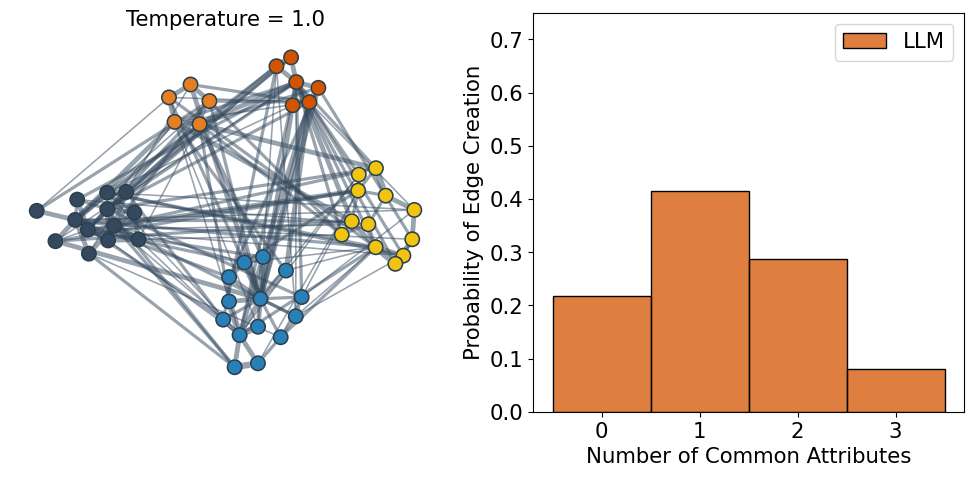

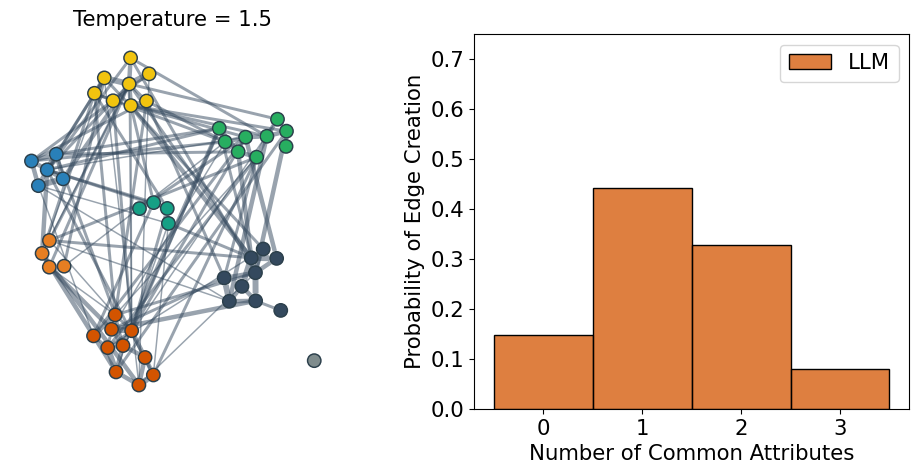

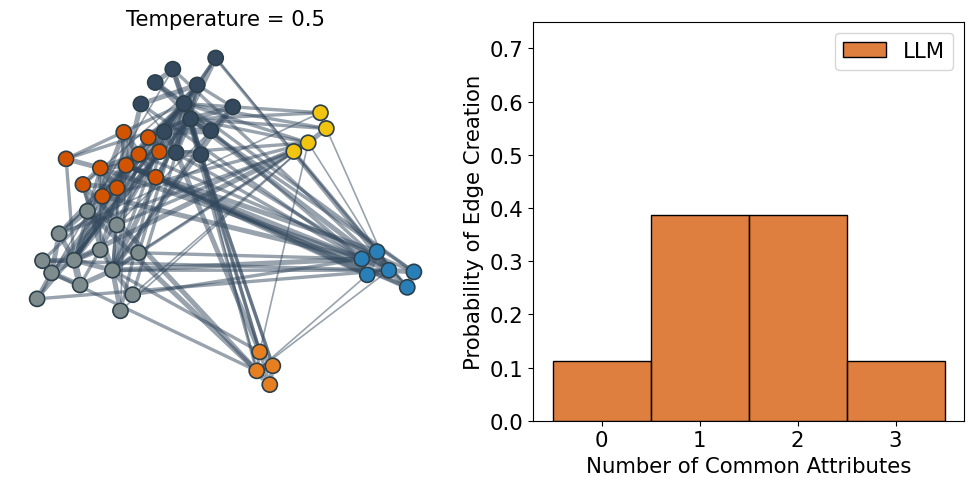

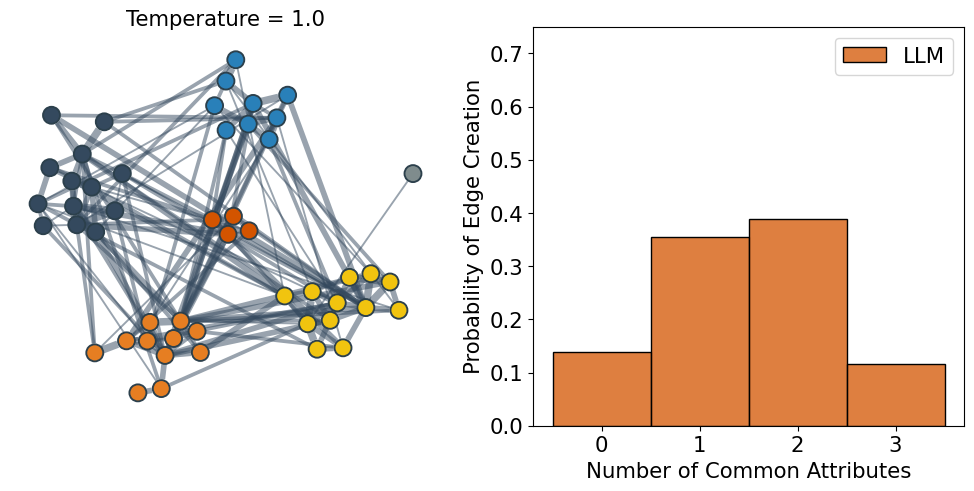

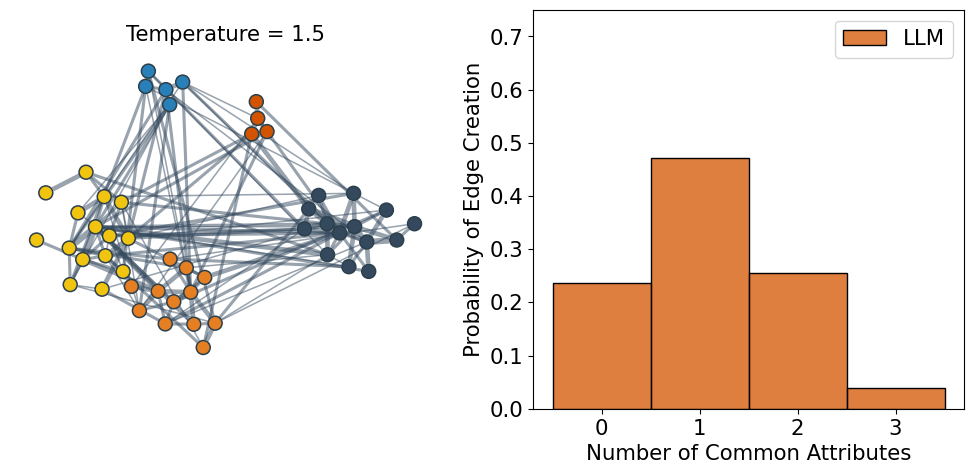

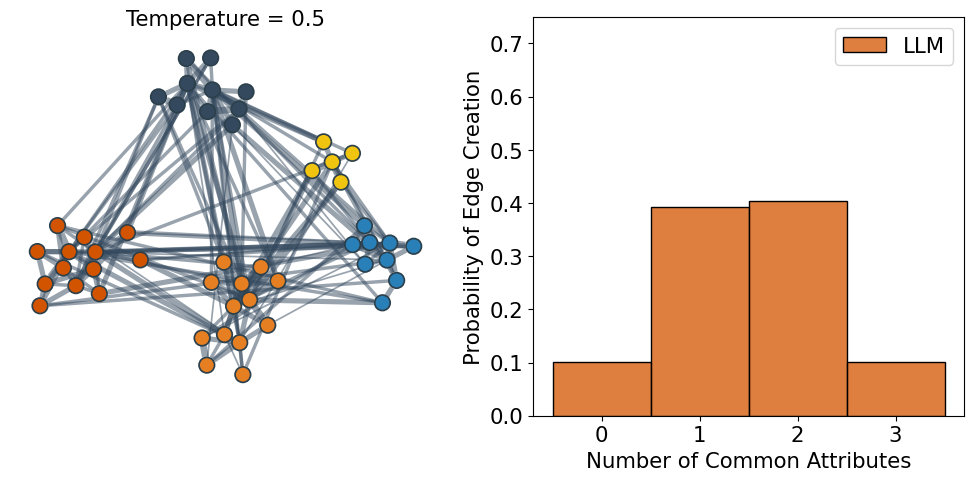

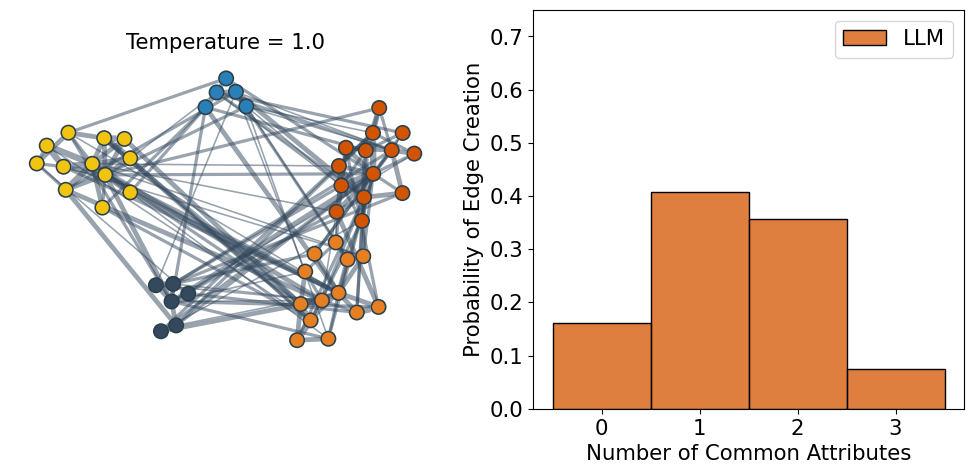

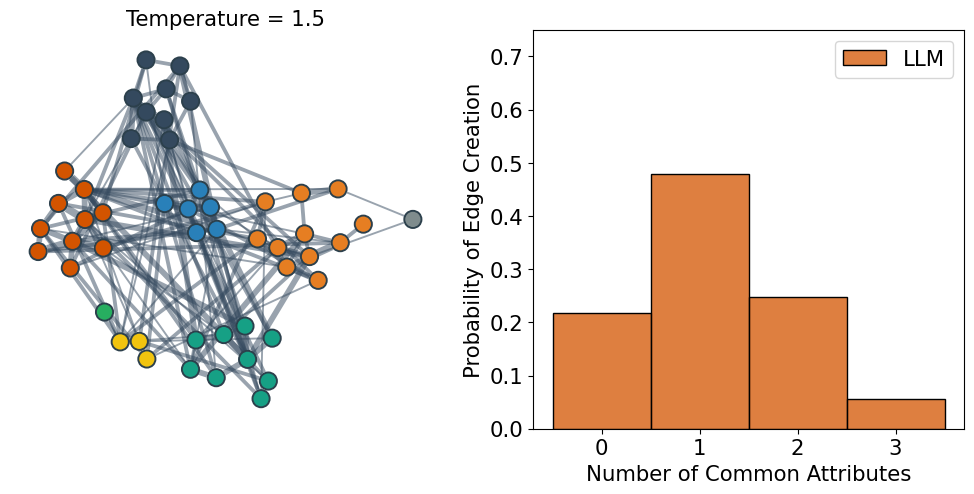

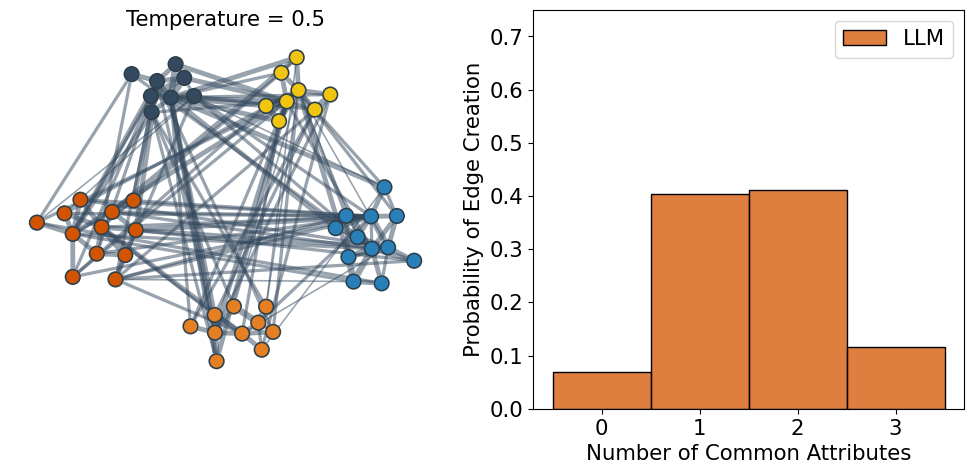

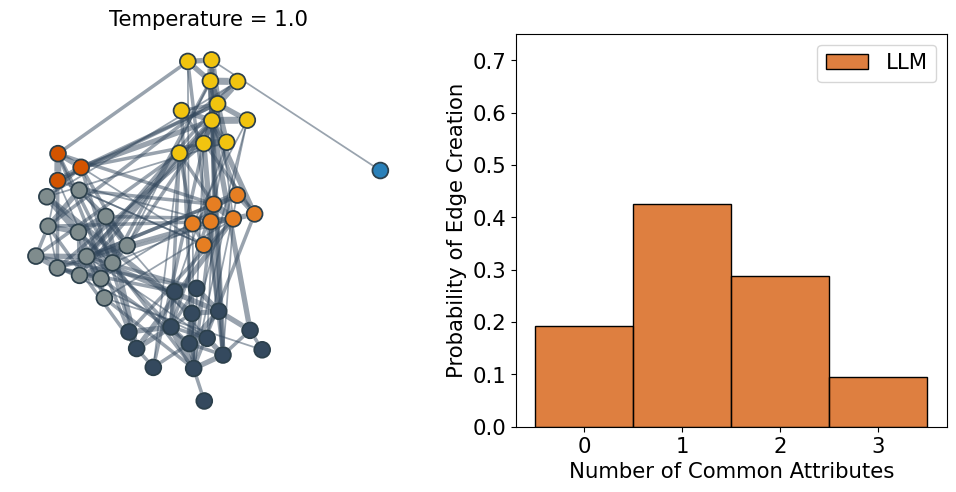

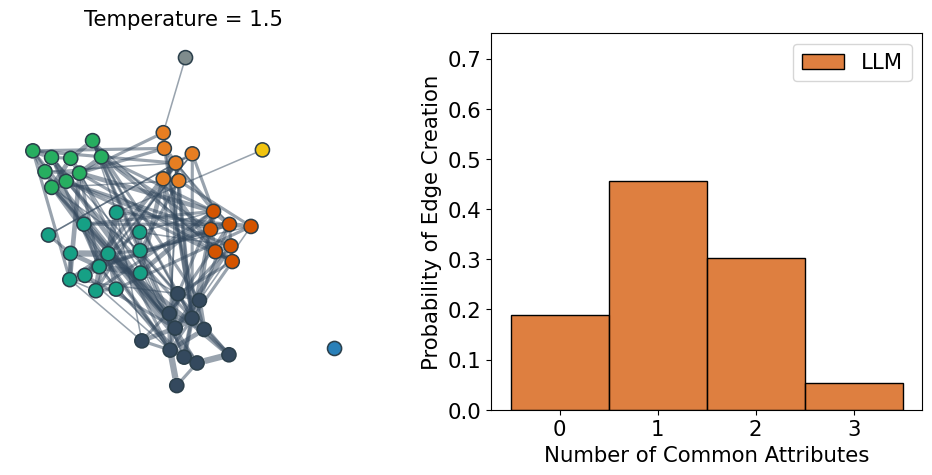

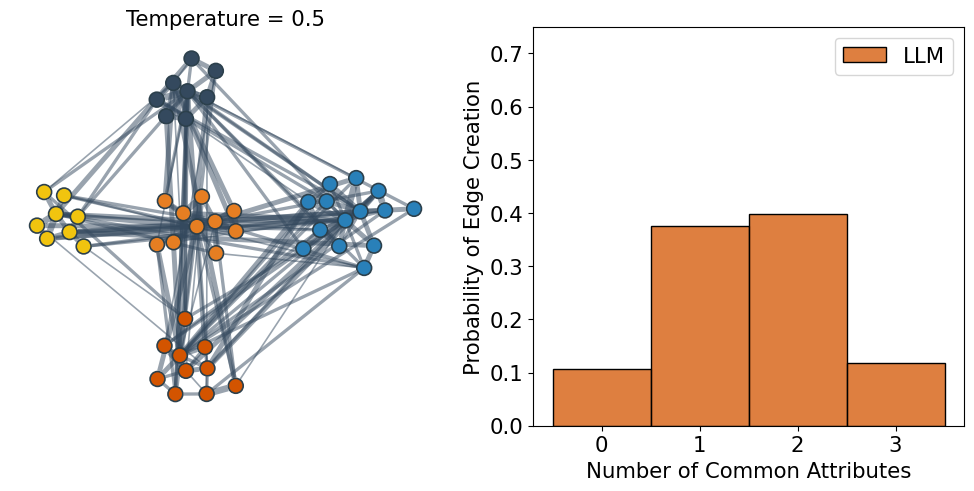

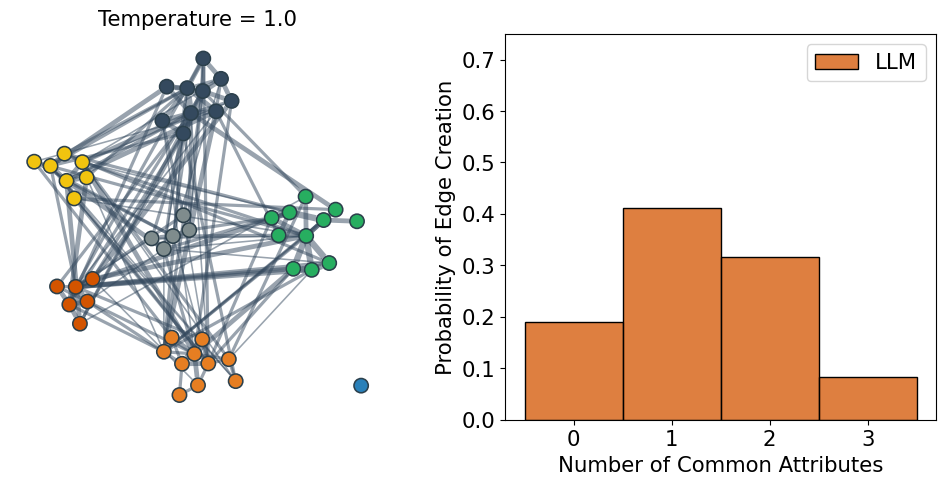

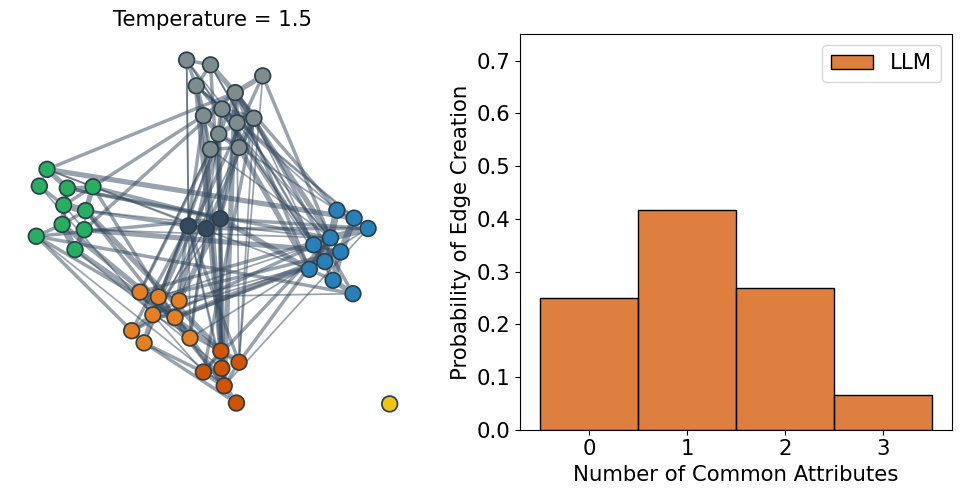

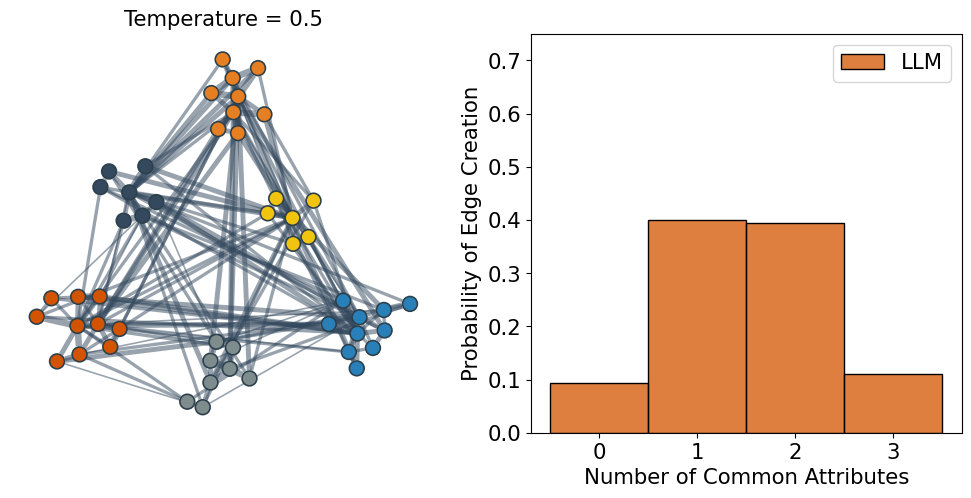

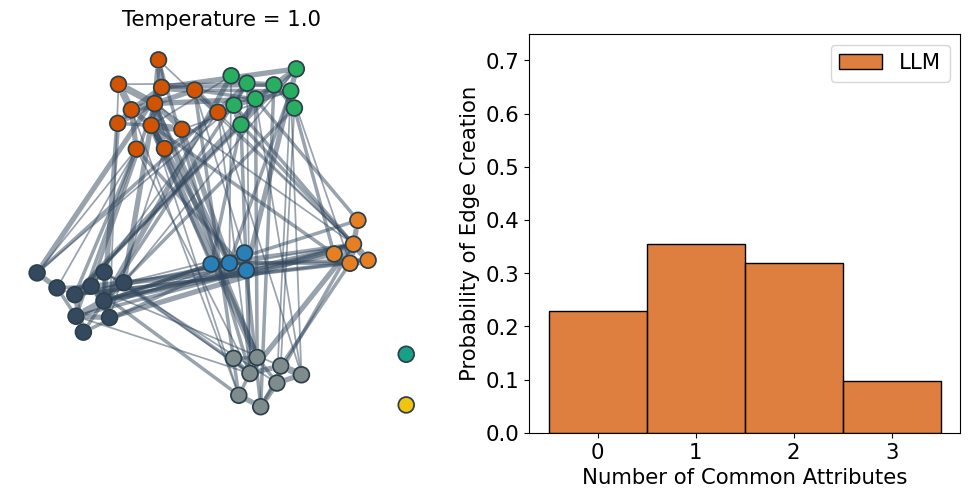

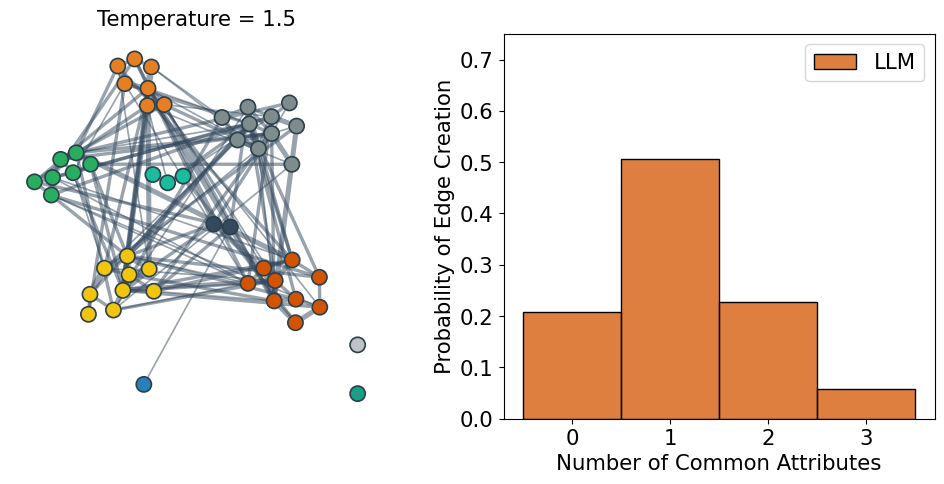

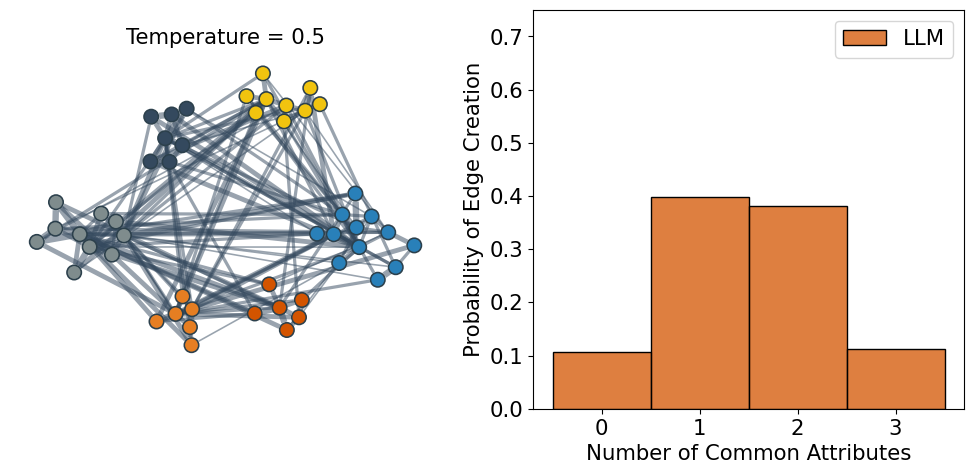

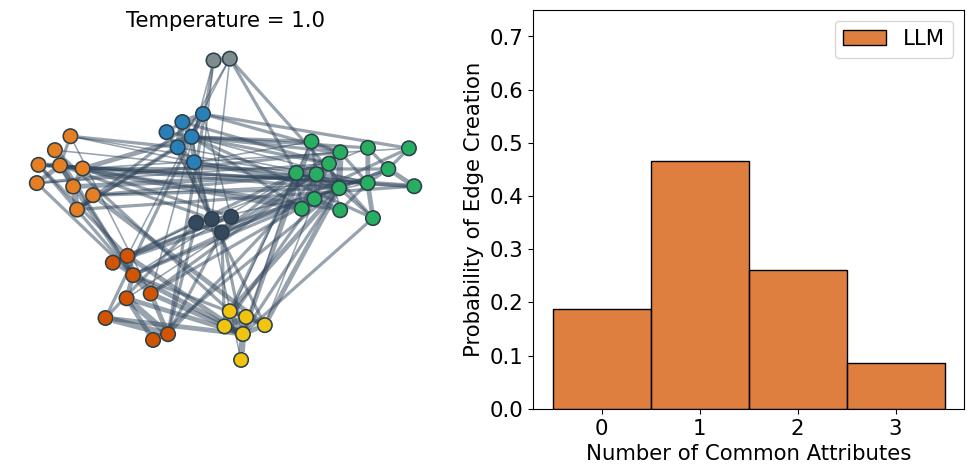

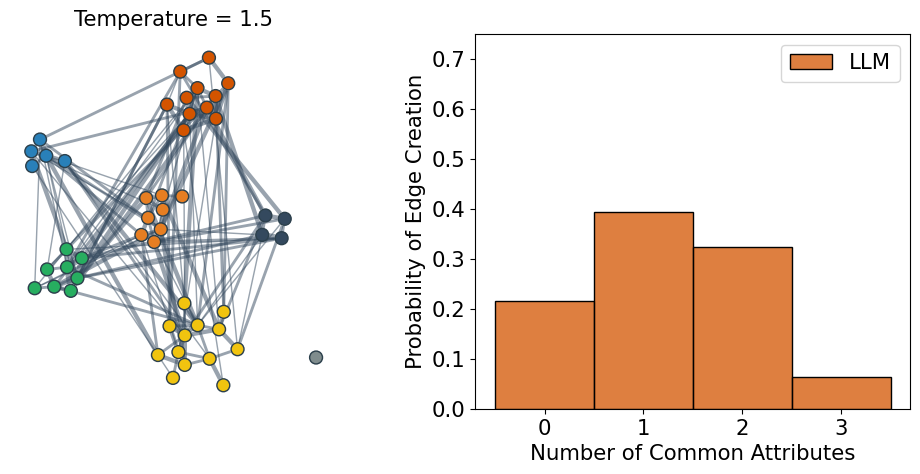

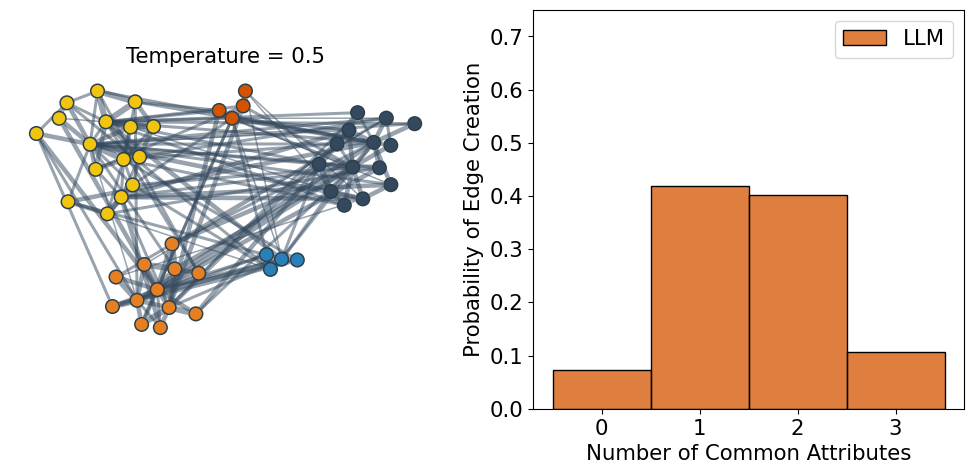

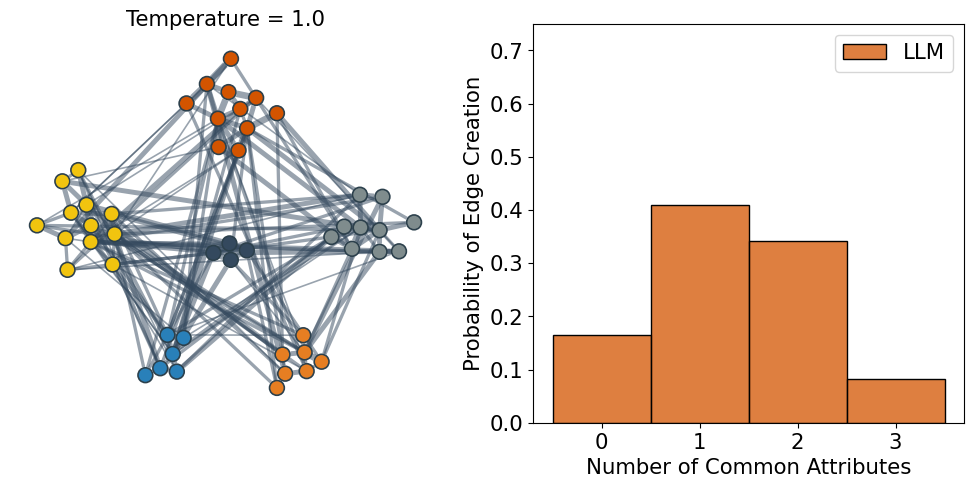

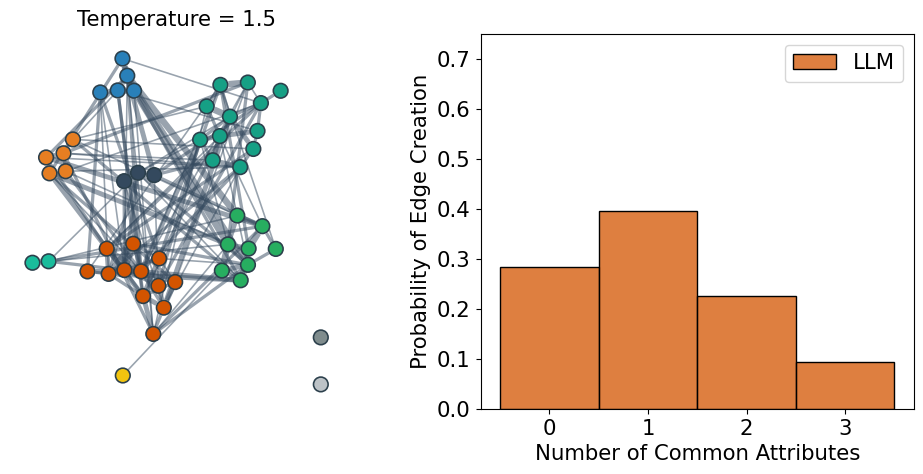

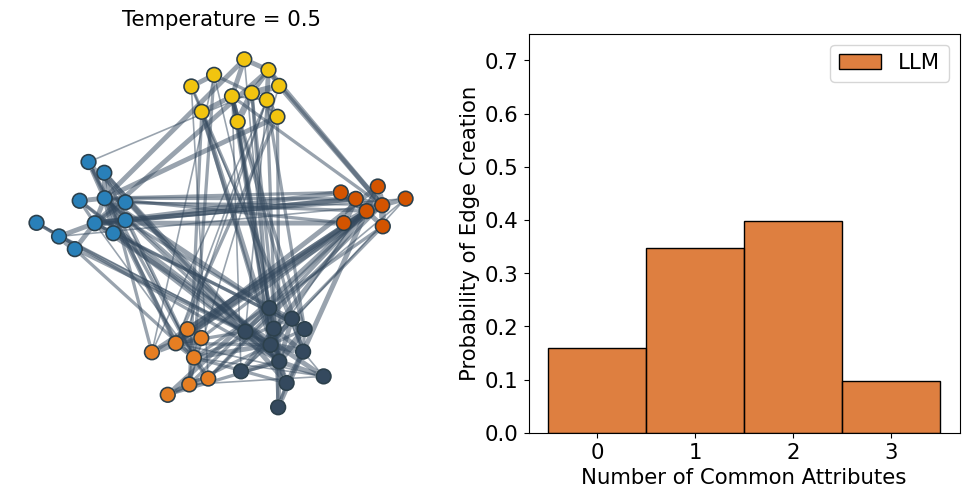

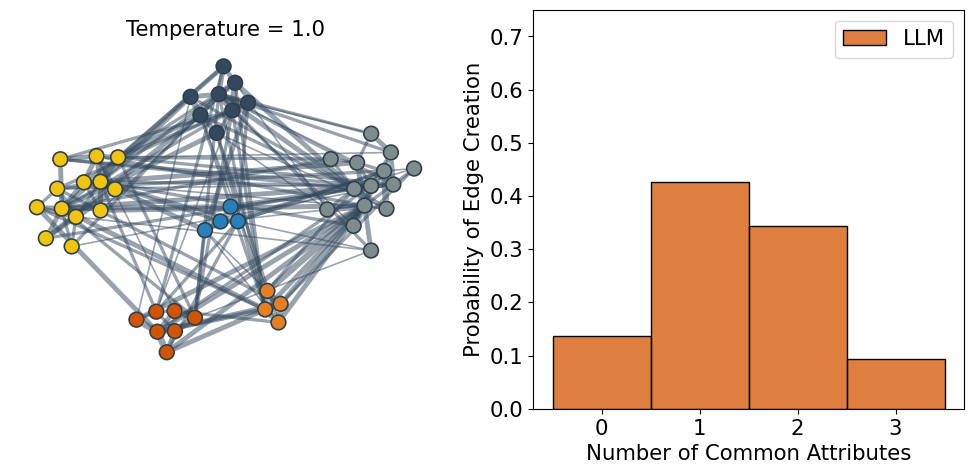

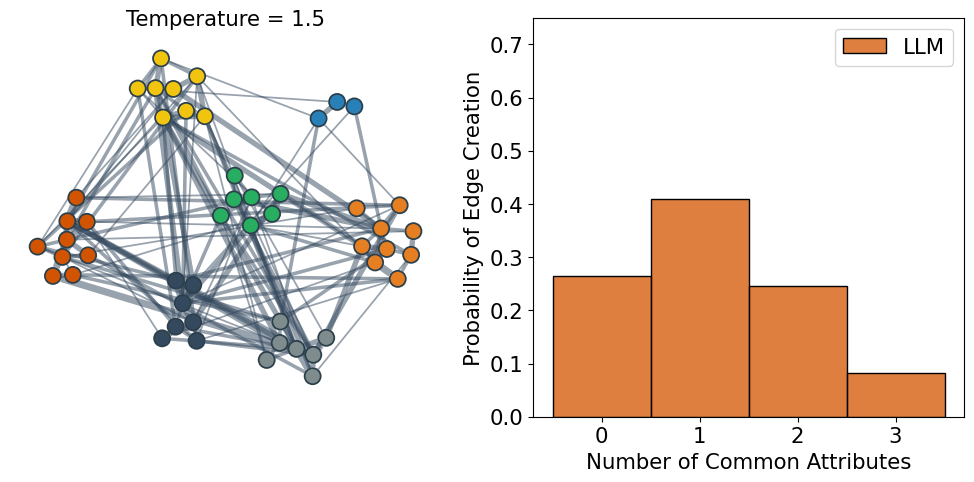

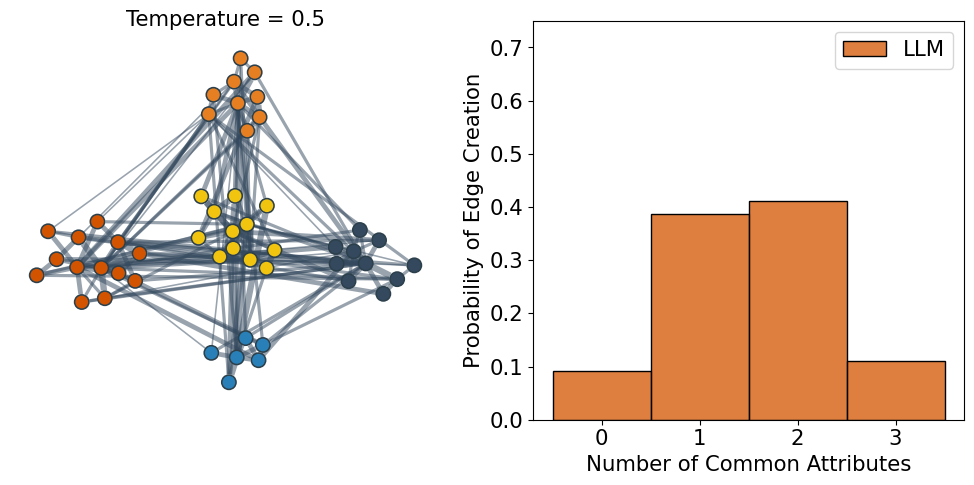

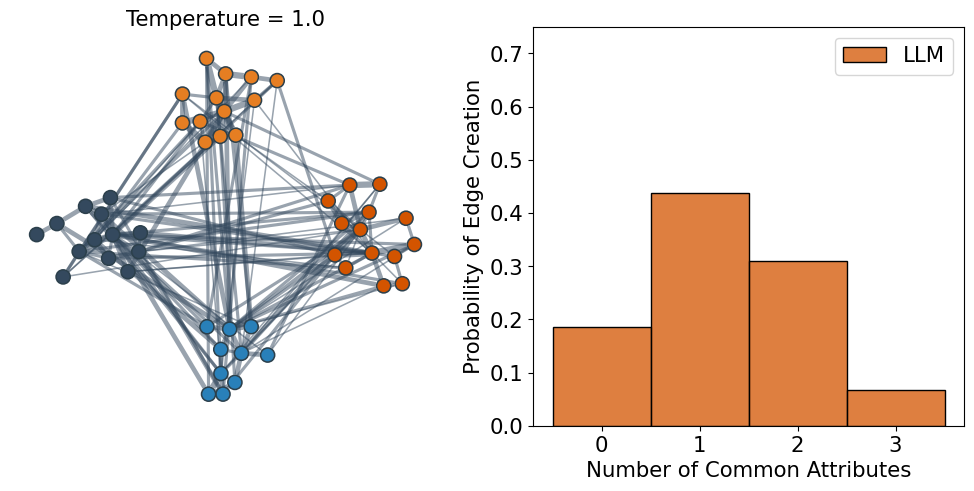

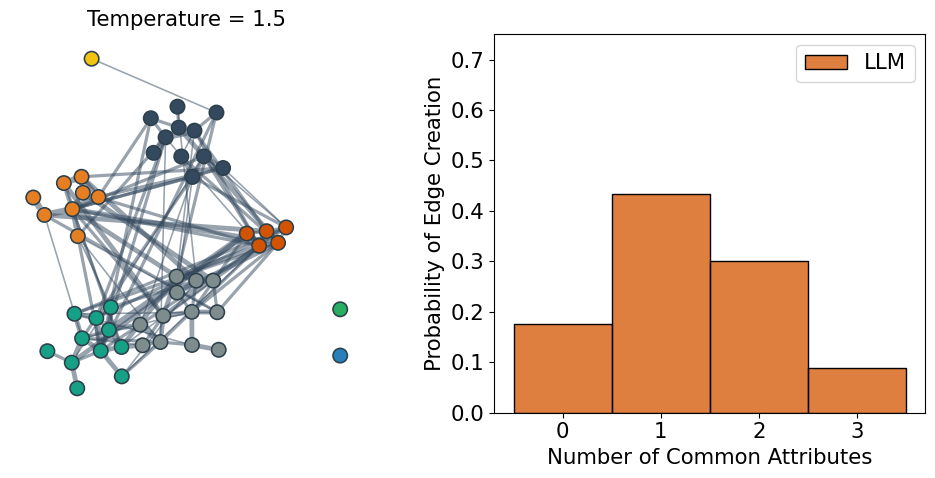

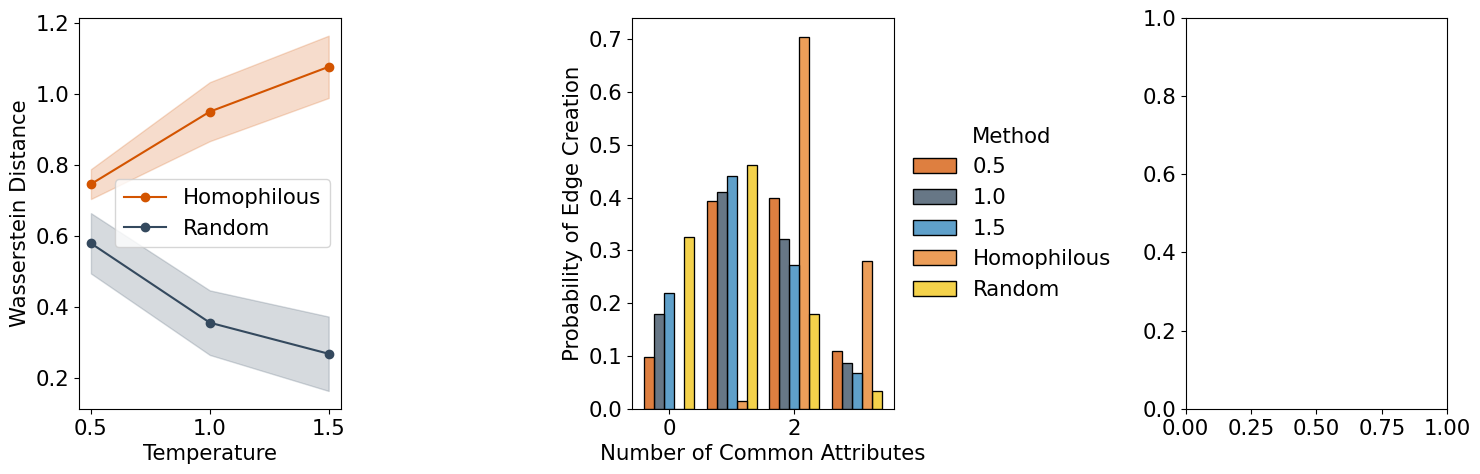

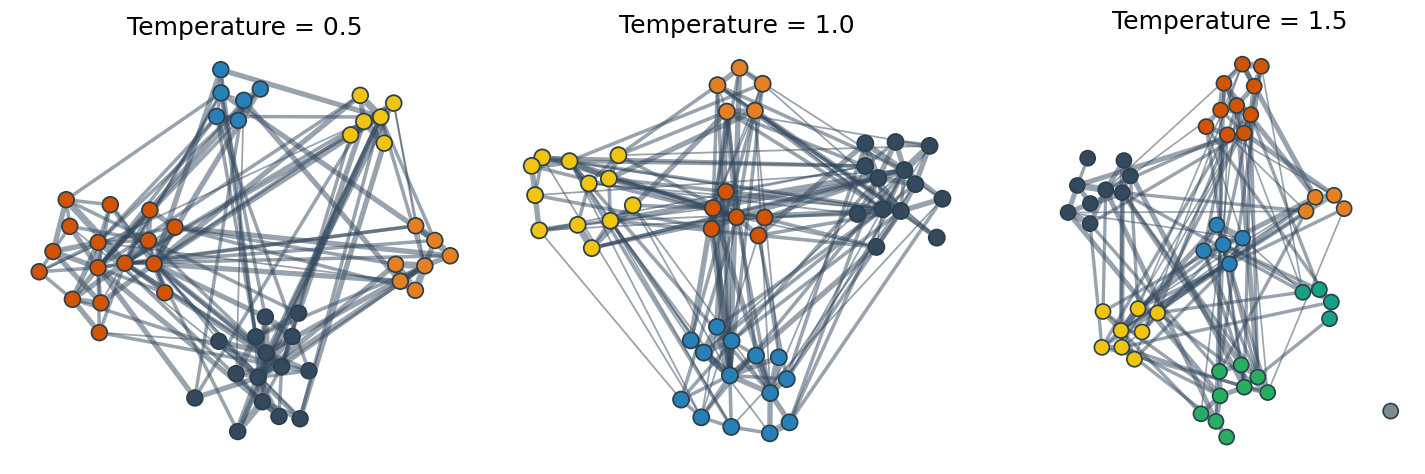

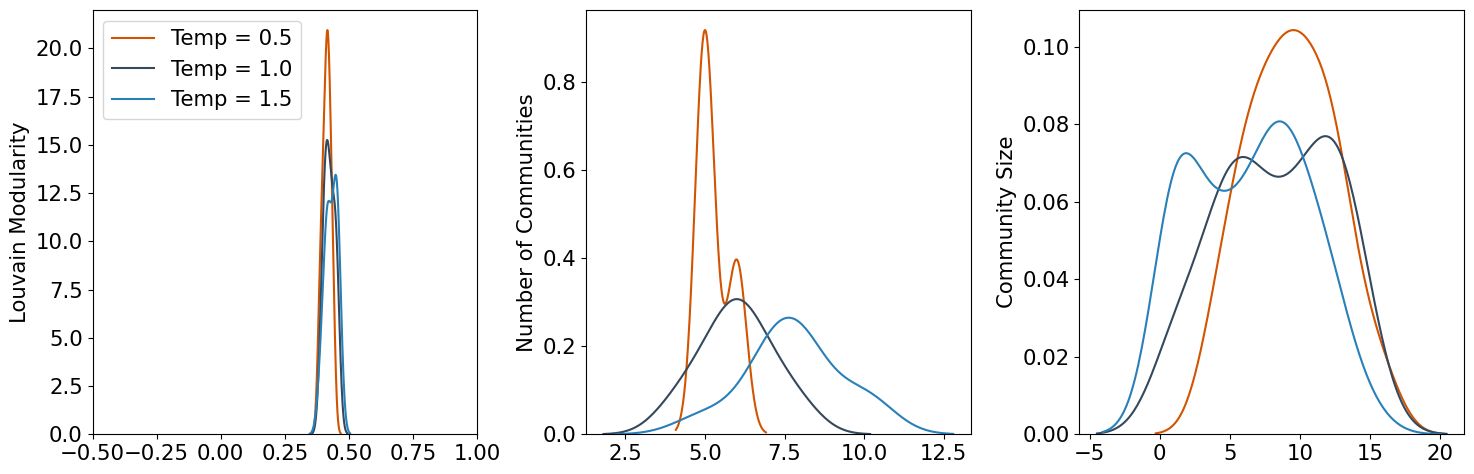

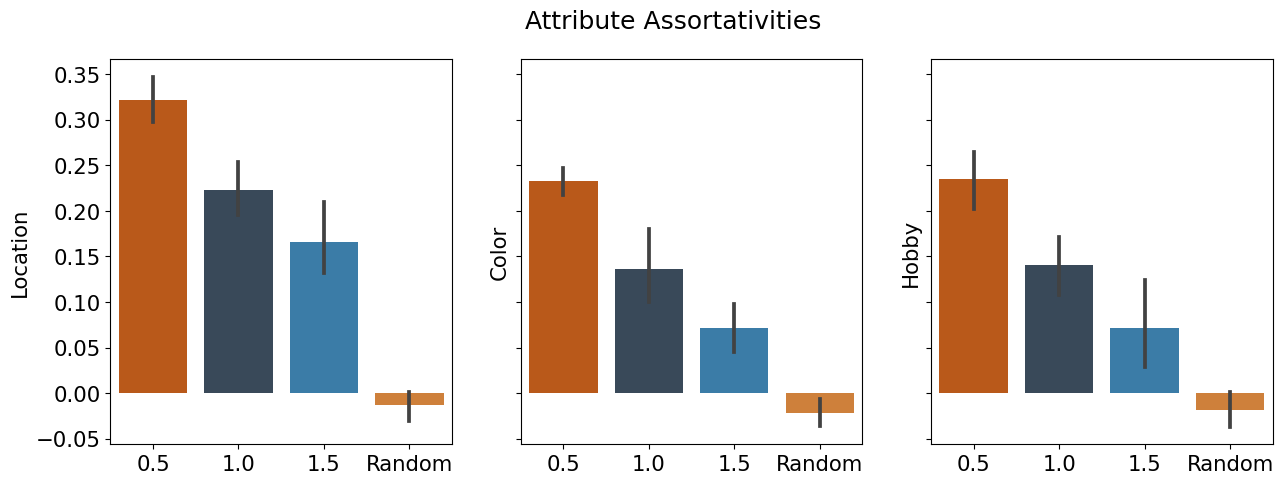

In [3]:
# LLM-based
run_network_formation_experiment(50, 50, 1, 10, 'outputs/principle_3.jsonl', [0.5, 1.0, 1.5], method='llm')
analyze_experiments('outputs/principle_3.jsonl')

In [ ]:
categories = [{'category': 'Hobbies', 'description': 'Reasons related to shared hobbies.'}, 
 {'category': 'Colors', 'description': 'Reasons related to sharing favorite colors.'}, 
 {'category': 'Location', 'description': 'Reasons related to living in the same city.'}]

summarize_reasons('outputs/principle_3_profiles.jsonl', categories=categories)

: 